![Title](https://i.imgur.com/iv3joFI.png)

## Introduction.

We are surrounded by words and numbers. They are everywhere - on roads, in our houses, on the papers. Literally, everywhere. It is impossible to keep track of all the text in this textually overrun world. The rule of thumb is simple - If a task is hard for humans, then write a program for it and that is exactly what we will do.

Character recognition is the conversion of printed or handwritten text (present in an image) into machine – encoded format, so it can stored efficiently, searched and edited more quickly or used as an input to text mining and other such applications.

This project aims to recognize characters from natural
images obtained from Google Street View.

## Table of Contents:

1. Google Colab: what is it?
2. Let's Peek at the data.
3. Process the data.
4. Image augmentation and preparing datafor image augmentation.
5. Defining our model.
6. Ploting the history.
7. Testing our model.
8. Confusion martix.
9. Exporting the model.

Let's get started.

## 1. Google Colab: What is it?

For this project, I will be using [Google Colab](https://render.githubusercontent.com/https://colab.research.google.com/). For those who are unaware, it is a research project created to disseminate ML education. They provide us with a wide array of resources like Tesla 80 GPUs or [TPU](https://en.wikipedia.org/wiki/Tensor_processing_unit)s for training our ML models.

![Colab Logo](https://colab.research.google.com/img/colab_favicon.ico)

If you do not have a High-end GPU and are looking forward to some good resources to train on, then this is your go-to spot. It is completely free but has limitations like a capped runtime and a fixed pool of resource to train on. I would suggest that when training massive models, you should opt for some paid cloud-based services like AWS or Paperspace.

### Connect to GDrive.

We will connect to google drive to access the dataset which I had uploaded earlier. Once you run the following command, you will be prompted to grant access permissions. 

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
base_path = "/content/gdrive/My Drive/Colab Notebooks/Street Alphabets/Data/"
img_dims = (32, 32)

### Import necessary libraries.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import MaxPooling2D 
from keras.layers import Flatten
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
import keras

## 2. Let's Peek at the data.
For training our model we will be using the [Chars74K dataset](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/), which houses **7705 images** obtained from natural sources.

The English language section is **127MB** big and on extracting you will find two folders and we are going to use the GoodImg folder. Our dataset is divided into **62 classes:**
  * 10 digits (0 - 9).
  * 26 Uppercase alphabets.
  * 26 lower case alphabets.

Let us have a look at few samples from the set.

![Samples](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/Samples/confusing_english.png)

This is going to be a fun excercise.

### The need for masking.

Going through the dataset you will notice that a lot of images contain intrusive parts from adjacent texts and this will surely confuse our neural network. Therefore, we will mask out the images such that we will have to deal with the characters only.

![Masking Explained](https://i.imgur.com/Vs3sxYU.png)

Notice that there are two folders in the Data directory and one of them contains masks. We will load each image file and the corresponding mask then multiply them before storing them in a Train/Test folder. We are creating these new folders to facilitate data augmentation.

In [0]:
Labels = [str(x) for x in range(10)]
Labels.extend([chr(x) for x in range(ord('A'),ord('Z')+1)])
Labels.extend([chr(x) for x in range(ord('a'),ord('z')+1)])

In [0]:
cm = np.delete(cm, (62), axis=0)


In [0]:
import cv2
import os
fraction = 0.1
for i in range(1, 63):
  
  source_image_path = base_path + "Bmp/" + "Sample" + str(i).zfill(3) + "/"
  mask_path = base_path + "Msk/" + "Sample" + str(i).zfill(3) + "/"
   
  count = 0
  for source_file in os.listdir(source_image_path):
    img = cv2.imread(os.path.join(source_image_path, source_file))
    mask = cv2.imread(os.path.join(mask_path, source_file))
    
    if count <= len(os.listdir(source_image_path)) * fraction:
      des = base_path + "Test/" + Labels[i-1] + "/" 
    else:
      des = base_path + "Train/" + Labels[i-1] + "/" 
     
    if not os.path.exists(os.path.dirname(des)):
      os.makedirs(os.path.dirname(des))
                          
    cv2.imwrite(des + source_file,img * mask)
    count += 1
    
  print("Processed:", Labels[i-1])

![New File System](https://i.imgur.com/xV1T5VM.png)

## 3. Image augmentation.
Plentiful high-quality data is the key to great machine learning models. But good data doesn’t grow on trees, and that scarcity can impede the development of a model. One way to get around a lack of data is to augment your dataset. Smart approaches to programmatic data augmentation can increase the size of your training set 10-fold or more. Even better, your model will often be more robust (and prevent overfitting) and can even be simpler due to a better training set.

We create new data by slightly altering the old ones to add variety. We can either shift the image a bit or rotate it or both. ImageDataGenerator lets us fiddle with a lot of characteristics to create augmented data. For data augmentation to work without any hitch we need to follow an elaborate directory structure. This helps the *ImageDataGenerator* to understand the label for each image.

To facilitate data augmentation you will have to follow an elaborate directory structure. You generally need three folders, but we will make do with just two. These folders contains another array of folders which are named after the classes of image contained within them. For e.g., in our case all the images of 'A' will be stored inside the folder named 'A' and so on. Same goes for the test set in this case.


![Data Augmentation](https://cdn-images-1.medium.com/max/750/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

We will define the Data generator as shown in the code below.

In [20]:
train_datagen = ImageDataGenerator(
                                   width_shift_range = 0.10,
                                   height_shift_range = 0.10,
                                   shear_range = 0.3,
                                   channel_shift_range = 0.2,
                                   rescale=1./255,
                                   validation_split=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                                                         directory = base_path + "Train/",
                                                         target_size = img_dims,
                                                         batch_size = 64,
                                                         class_mode = 'categorical',
                                                         subset = 'training'
                                                        )

validation_data_generator = train_datagen.flow_from_directory( 
                                                                   directory = base_path + "Train/",
                                                                   target_size = img_dims,
                                                                   batch_size = 64,
                                                                   class_mode = 'categorical',
                                                                   subset = 'validation'
                                                                  )
test_data_generator = test_datagen.flow_from_directory(
                                                          directory = base_path + "Test/",
                                                          target_size = img_dims,
                                                          batch_size = 64,
                                                          class_mode = 'categorical',
                                                          shuffle = False
                                                      )

Found 5593 images belonging to 62 classes.
Found 1371 images belonging to 62 classes.
Found 792 images belonging to 63 classes.


## 4. Define the model.

### Architecture.
Our model consists of a Sequential model which contains six convolution layers and three fully connected layers.

### Hyper-parameters.

In this sequential neural network, I have employed a l2 kernel_regularizer. l2 regularization peanlizes large weigths to prevent overfitting. This penalizes peaky weights and makes sure that all the inputs are considered. During gradient descent parameter update, the above L2 regularization ultimately means that every weight is decayed linearly, that’s why called weight decay.

### Callbacks.

Callback functions are those functions which are called at the end of every epoch and in this model, we use two callback functions - ReduceLROnPlateau and EarlyStopping.

1. ReduceLROnPlateau: monitors a certain variable, in this case, validation loss and alters the learning rate when the value stops significantly changing after some certain number of epochs (patience).

2. ModelCheckpoint: Saves the best version of our model along with the weights, so that in case any crash occurs, our model can be recovered.

3. EarlyStopping: Once the improvement of our model stalls for a set number of epochs, the training is terminated. 

In [0]:
import datetime

#######HYPERPARAMATERS###########
epochs = 100
batch_size = 64
learning_rate = 0.001
weight_decay = 0.0005
#################################

model = Sequential()
model.add(Conv2D(128, (3,3), padding='same', input_shape=(32, 32, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, (3,3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(Labels), activation='softmax'))

adam_opt = keras.optimizers.adam(lr = learning_rate)
model.compile(optimizer = adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

t0 = datetime.datetime.now()
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
checkpointer = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/Street Alphabets/Models/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
                               
history = model.fit_generator(
                               train_data_generator,
                               steps_per_epoch = train_data_generator.samples/batch_size,
                               epochs = epochs,
                               callbacks = [lr_reducer, checkpointer, early_stopper],
                               validation_data = validation_data_generator,
                               validation_steps = validation_data_generator.samples/batch_size,
                               shuffle = True
                             )
training_time = datetime.datetime.now() - t0
print("Total training time =", training_time)

## 5. Plotting the history
the *model.fit* function returns a structure called history which contains all the details of our training process. We will use the history model to plot our losses and accuracies to analyze the process. The plots are quite self explainatory.

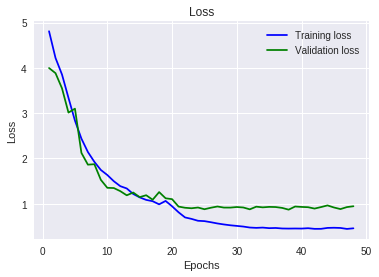

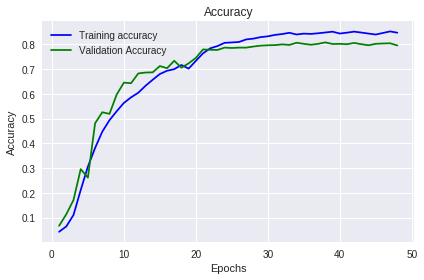

In [22]:
def plot_history(history):
  
  loss_values = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
  val_loss_values = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
  acc_values = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
  val_acc_values = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
  
  if len(loss_values) == 0:
    print("Incomplete Data")
    return
  
  no_epochs = range(1, len(history.history[loss_values[0]]) + 1)
  plt.figure(1)
  for l in loss_values:
    plt.plot(no_epochs, history.history[l], 'b', label = 'Training loss')
  for l in val_loss_values:
    plt.plot(no_epochs, history.history[l], 'g', label = 'Validation loss')
    
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
  plt.figure(2)  
  for l in acc_values:
    plt.plot(no_epochs, history.history[l], 'b', label = 'Training accuracy')
  for l in val_acc_values:
    plt.plot(no_epochs, history.history[l], 'g', label = 'Validation Accuracy')
    
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout()
  plt.show()
  
plot_history(history)
   

Even though we deployed our model to train for 100 epochs, the training stopped at the 48th epoch as the validation loss had stalled and no further imporvement was observed. 

## 6. Testing out model.

In [23]:
import numpy as np
test_data_generator.reset()

actual_class_indices = test_data_generator.classes
preds = model.predict_generator(test_data_generator)
predicted_class_indices = np.argmax(preds, axis=1)

right_predictions = 0

for actual, predicted in zip(actual_class_indices, predicted_class_indices):
  if actual == predicted: 
    right_predictions += 1

print("Accuracy =", right_predictions/len(actual_class_indices)*100)

Accuracy = 79.92424242424242


## 7. Confusion matrix.
Plotting out a confusion matrix is a great way of knowing where our model faltered. It will help us identify the mistakes our model can commit. 

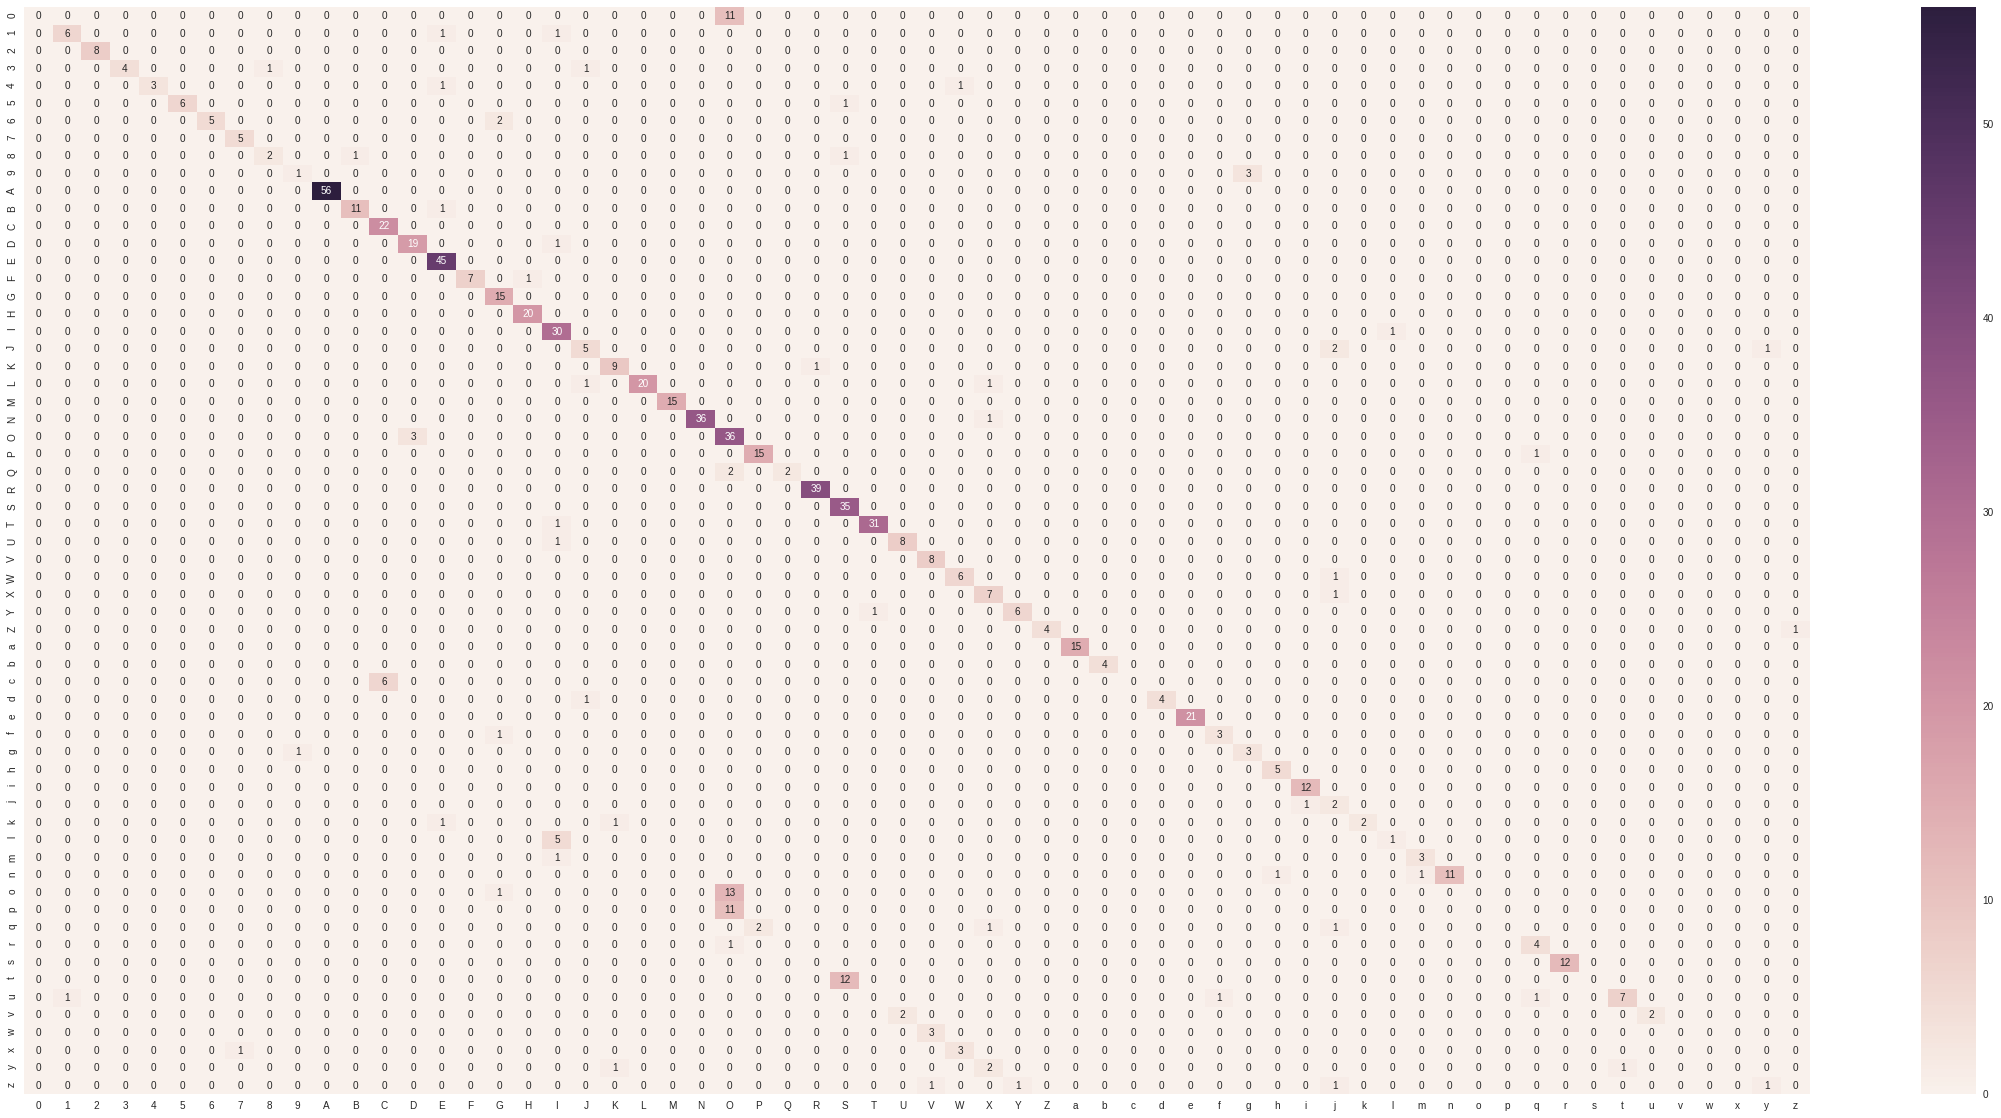

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

cm = confusion_matrix(actual_class_indices, predicted_class_indices)
cm = np.delete(cm,(62),axis = 0)
cm = np.delete(cm,(62),axis = 1)
df_cm = pd.DataFrame(cm, index = [obj for obj in Labels], columns = [obj for obj in Labels])
plt.figure(figsize = (40,20))
sn.heatmap(df_cm, annot=True)

### All that our model got wrong.
Just a look at the confusion matrix reveals all the mistakes our model is making.
1. our model can get confused between similar looking upper case and lower case alphabets.
2. 'O' was mistaken for 0 at times.
3. Similar looking characters can confuse this model - o, O, and 0 or i, j.

## 8. Exporting the model.
We will save the model for later use in other applications.

In [25]:
from keras.models import model_from_json

model_json = model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/Street Alphabets/Models/CRmodel.json", "w") as json_file:
    json_file.write(model_json)
 # serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/Street Alphabets/Models/CRmodel_weights.h5")
print("Saved model to disk")

Saved model to disk
